In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
file_id = '1HdqwRuDCiX4xLNgpA9P_jcC0vCZZAiHQ'
url = 'https://drive.google.com/uc?id={}'.format(file_id)
data = pd.read_csv(url)

In [ ]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
lat,92887.0,-3.404577,4.354584,-11.00,-7.885,-2.91,0.14,6.00
lon,92887.0,119.159707,10.833202,94.02,113.170,121.16,126.90,142.00
depth,92887.0,49.009399,76.761070,2.00,10.000,16.00,54.00,750.00
mag,92887.0,3.592788,0.834042,1.00,3.000,3.50,4.20,7.90
strike1,2735.0,170.142852,88.359267,0.00,107.550,144.60,217.50,359.20
dip1,2735.0,60.202121,19.699252,2.30,46.950,62.30,76.40,90.00
rake1,2735.0,30.358062,99.957906,-180.00,-28.500,57.60,100.15,180.00
strike2,2735.0,197.450303,118.920519,0.00,63.115,240.72,297.48,359.98
dip2,2735.0,56.576344,21.274923,1.50,39.400,58.40,74.70,90.00
rake2,2735.0,35.250018,98.235894,-180.00,-19.900,56.50,112.60,180.00


In [ ]:
data.columns

Index(['tgl', 'ot', 'lat', 'lon', 'depth', 'mag', 'remark', 'strike1', 'dip1',
       'rake1', 'strike2', 'dip2', 'rake2'],
      dtype='object')

In [ ]:
import datetime
import time
import pandas as pd

# Assuming 'data' is your original DataFrame
timestamp = []

for d, t in zip(data['tgl'], data['ot']):
    try:
        # Combine the date and time with the appropriate separators
        datetime_str = d + ' ' + t
        # Adjust the format based on your data's actual format
        ts = datetime.datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S.%f')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        # Handle the ValueError case by appending a placeholder value (e.g., NaN)
        timestamp.append(ValueError)
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp

final_data = data.drop(['tgl', 'ot', 'remark', 'strike1', 'dip1', 'rake1', 'strike2', 'dip2', 'rake2'], axis=1)
final_data = final_data[final_data.Timestamp != 'ValueError']
final_data.head()


,lat,lon,depth,mag,Timestamp
0,-9.18,119.06,10,4.9,1.225573e+09
1,-6.55,129.64,10,4.6,1.225573e+09
2,-7.01,106.63,121,3.7,1.225561e+09
3,-3.30,127.85,10,3.2,1.225557e+09
4,-6.41,129.54,70,4.3,1.225556e+09


In [ ]:
!python -m pip install basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.7/860.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 36.1 MB/s eta 0:00:00


In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
# setup Lambert Conformal basemap.
# set resolution=None to skip processing of boundary datasets.
m = Basemap(projection='mill',
            llcrnrlon=94,
            llcrnrlat=-13,
            urcrnrlon=142,
            urcrnrlat=8,
            resolution='c')

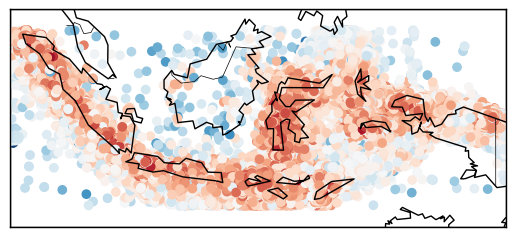

In [ ]:
# Convert latitudes and longitudes to map coordinates
x, y = m(final_data['lon'], final_data['lat'])

# Plot the data on the map
m.scatter(x, y, c=final_data['mag'], cmap='RdBu')
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
plt.show()
# Show the map
plt.show()

In [ ]:
column_indices = {name: i for i, name in enumerate(final_data.columns)}

n = len(final_data)
train_df = final_data[0:int(n*0.7)]
val_df = final_data[int(n*0.7):int(n*0.9)]
test_df = final_data[int(n*0.9):]

num_features = final_data.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

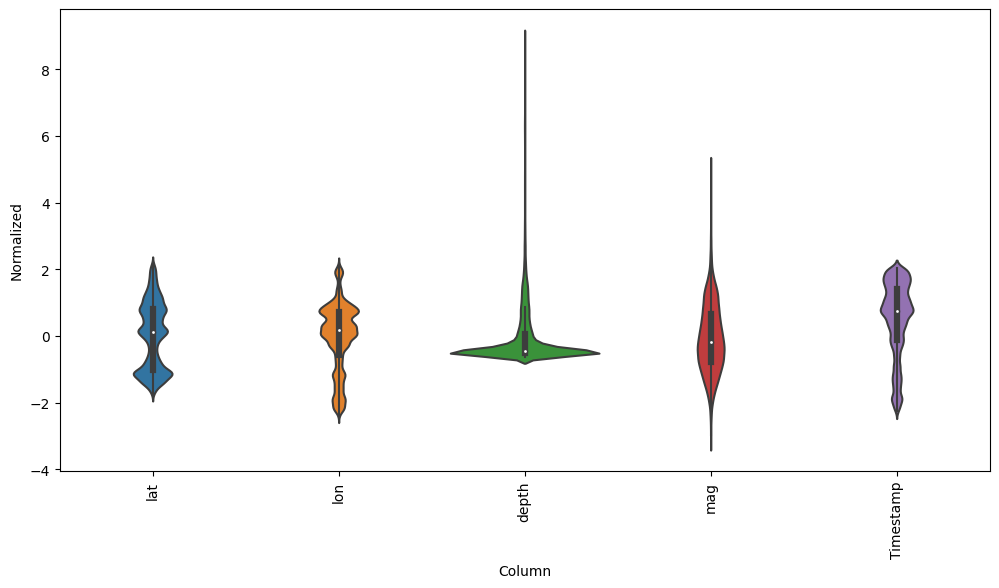

In [ ]:
import seaborn as sns

df_std = (final_data - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(final_data.keys(), rotation=90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
wingen = WindowGenerator(input_width=42, label_width=1, shift=1,
                     label_columns=['mag'])
wingen

Total window size: 43
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Label indices: [42]
Label column name(s): ['mag']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
import tensorflow as tf
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:wingen.total_window_size]),
                           np.array(train_df[100:100+wingen.total_window_size]),
                           np.array(train_df[200:200+wingen.total_window_size])])

example_inputs, example_labels = wingen.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 43, 5)
Inputs shape: (3, 42, 5)
Labels shape: (3, 1, 1)


In [ ]:
wingen.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col1='mag', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index1 = self.column_indices[plot_col1]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col1} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index1],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index1 = self.label_columns_indices.get(plot_col1, None)
    else:
      label_col_index1 = plot_col_index1

    if label_col_index1 is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index1],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index1],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Occurence')

WindowGenerator.plot = plot

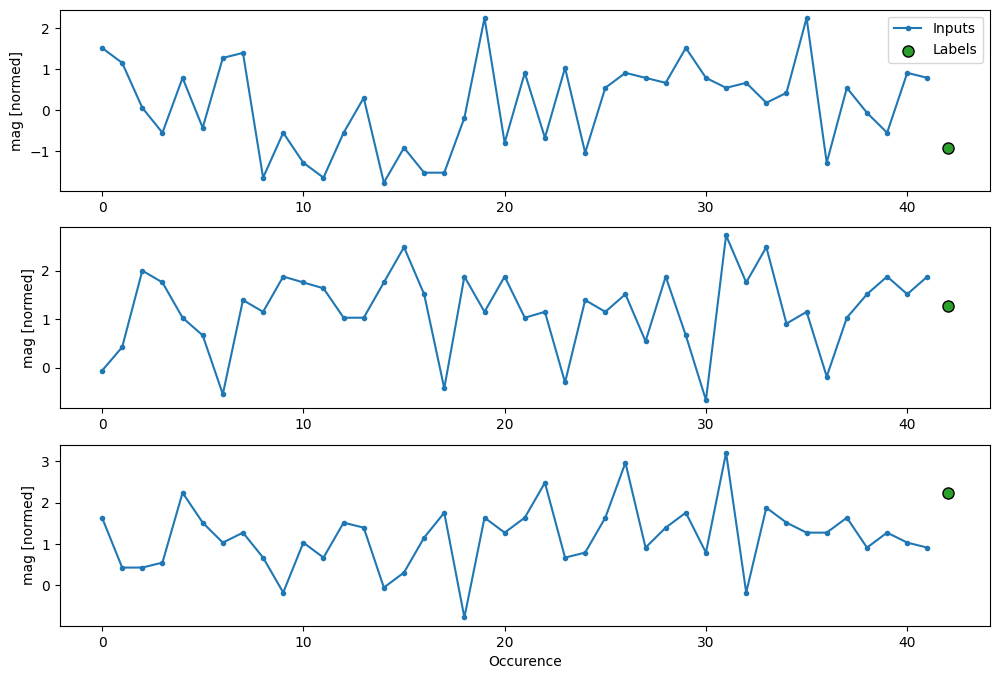

In [ ]:
wingen.plot()

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair.
wingen.train.element_spec

(TensorSpec(shape=(None, 42, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in wingen.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 42, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['mag'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['mag']

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['mag'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

581/581 [==============================] - 4s 5ms/step - loss: 1.4163 - mean_absolute_error: 0.9154


In [ ]:
wide_window = WindowGenerator(
    input_width=294, label_width=294, shift=1,
    label_columns=['mag'])

wide_window

Total window size: 295
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 294, 5)
Output shape: (32, 294, 1)


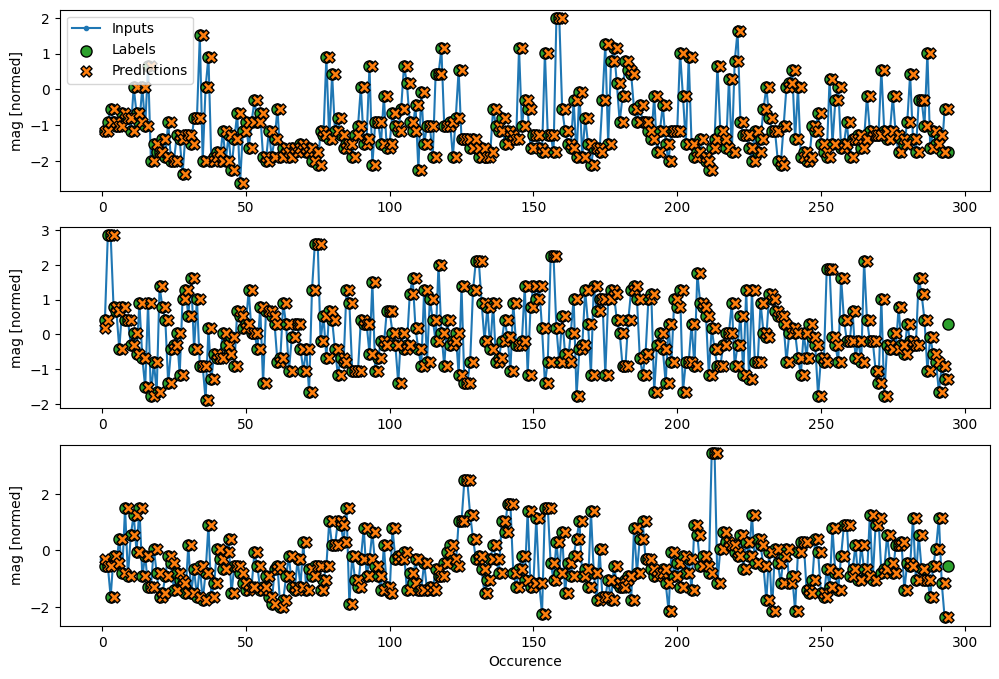

In [ ]:
wide_window.plot(baseline)

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)
dense.save('dense_out_mag.h5')

Epoch 1/20
2032/2032 [==============================] - 26s 11ms/step - loss: 0.8754 - mean_absolute_error: 0.7641 - val_loss: 0.9165 - val_mean_absolute_error: 0.7635
Epoch 2/20
2032/2032 [==============================] - 11s 5ms/step - loss: 0.8681 - mean_absolute_error: 0.7612 - val_loss: 0.9127 - val_mean_absolute_error: 0.7627
Epoch 3/20
2032/2032 [==============================] - 12s 6ms/step - loss: 0.8667 - mean_absolute_error: 0.7605 - val_loss: 0.9106 - val_mean_absolute_error: 0.7619
Epoch 4/20
2032/2032 [==============================] - 13s 6ms/step - loss: 0.8658 - mean_absolute_error: 0.7600 - val_loss: 0.9109 - val_mean_absolute_error: 0.7614
Epoch 5/20
2032/2032 [==============================] - 17s 8ms/step - loss: 0.8652 - mean_absolute_error: 0.7597 - val_loss: 0.9089 - val_mean_absolute_error: 0.7616
Epoch 6/20
2032/2032 [==============================] - 10s 5ms/step - loss: 0.8645 - mean_absolute_error: 0.7593 - val_loss: 0.9093 - val_mean_absolute_error: 0.76

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


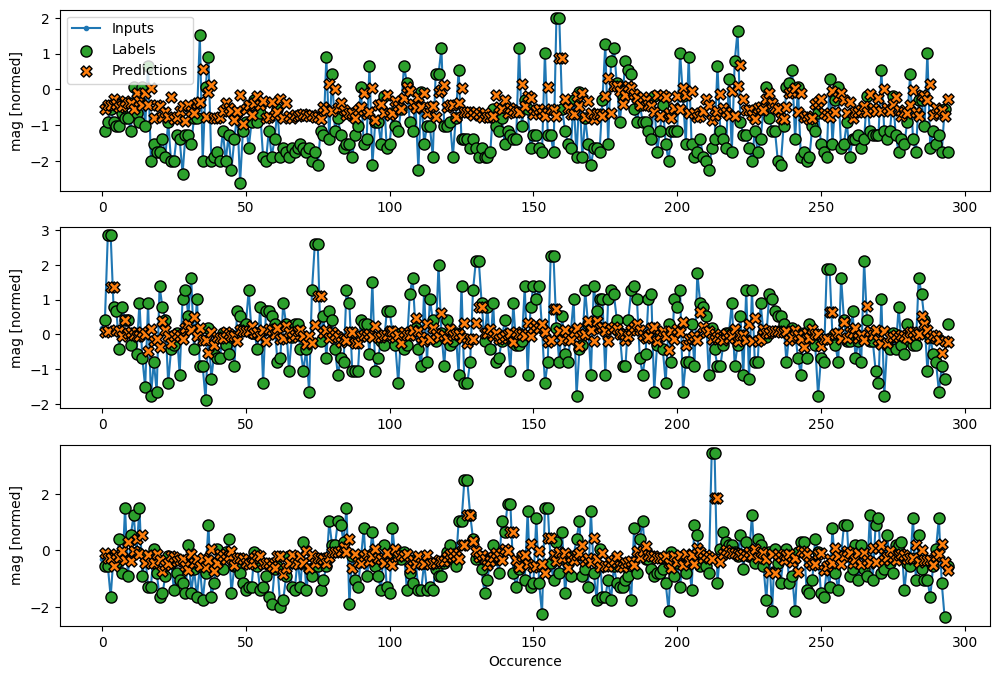

In [ ]:
wide_window.plot(dense)

In [ ]:
CONV_WIDTH = 294
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=294,
    shift=1,
    label_columns=['mag'])

conv_window

Total window size: 295
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

Text(0.5, 1.0, 'Given in average 147 occurences per week, predict 3 weeks into the future.')

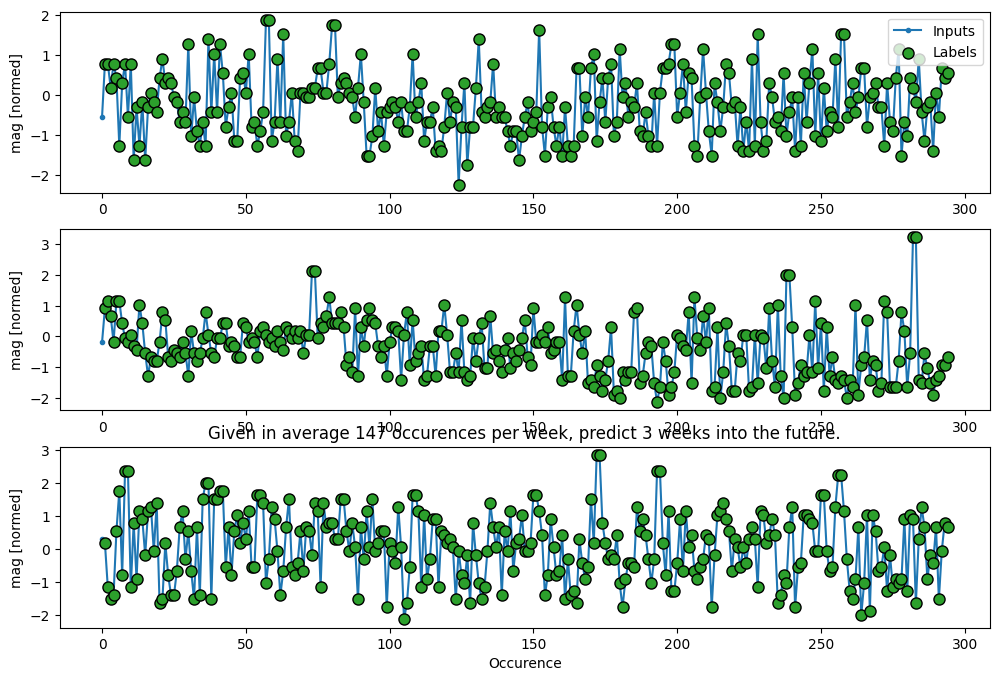

In [ ]:
conv_window.plot()
plt.title("Given in average 147 occurences per week, predict 3 weeks into the future.")

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 294, 5)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)
conv_model.save('conv_model_out_mag.h5')

Epoch 1/20
2023/2023 [==============================] - 19s 9ms/step - loss: 0.9039 - mean_absolute_error: 0.7675 - val_loss: 0.9790 - val_mean_absolute_error: 0.7859
Epoch 2/20
2023/2023 [==============================] - 15s 8ms/step - loss: 0.9004 - mean_absolute_error: 0.7661 - val_loss: 0.9781 - val_mean_absolute_error: 0.7870
Epoch 3/20
2023/2023 [==============================] - 16s 8ms/step - loss: 0.9002 - mean_absolute_error: 0.7660 - val_loss: 0.9787 - val_mean_absolute_error: 0.7863
Epoch 4/20
2023/2023 [==============================] - 18s 9ms/step - loss: 0.9002 - mean_absolute_error: 0.7660 - val_loss: 0.9779 - val_mean_absolute_error: 0.7884
Epoch 5/20
2023/2023 [==============================] - 15s 8ms/step - loss: 0.9001 - mean_absolute_error: 0.7660 - val_loss: 0.9779 - val_mean_absolute_error: 0.7879
Epoch 6/20
2023/2023 [==============================] - 16s 8ms/step - loss: 0.9000 - mean_absolute_error: 0.7659 - val_loss: 0.9792 - val_mean_absolute_error: 0.785

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 294, 5)
Labels shape: (32, 294, 1)
Output shape: (32, 1, 1)


In [ ]:
LABEL_WIDTH = 147
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['mag'])

wide_conv_window

Total window size: 441
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 440, 5)
Labels shape: (32, 147, 1)
Output shape: (32, 147, 1)


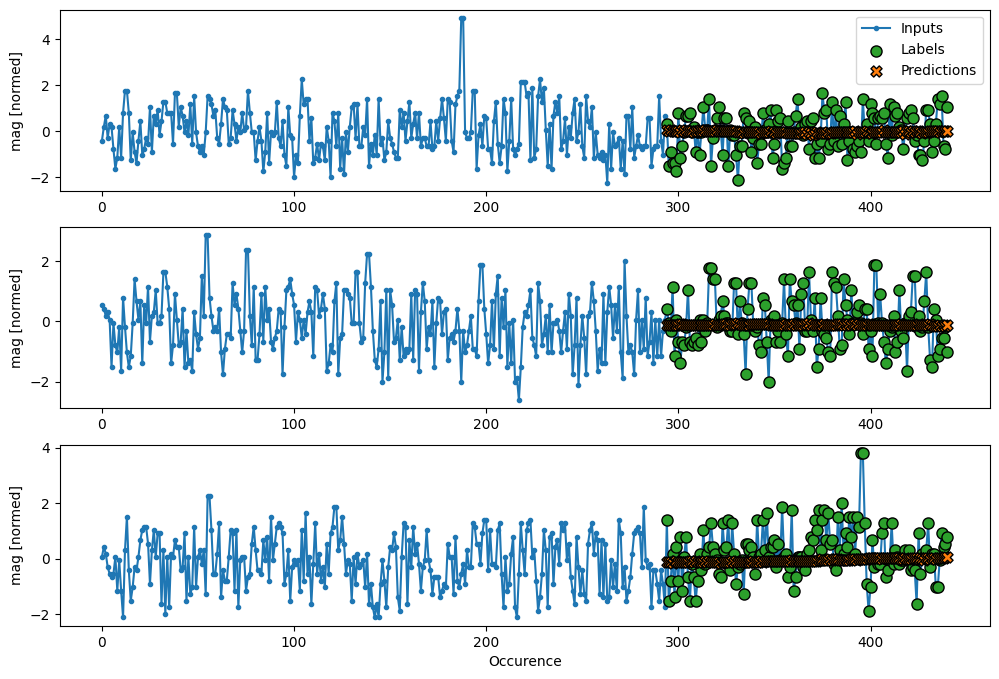

In [ ]:
wide_conv_window.plot(conv_model)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 294, 5)
Output shape: (32, 294, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
lstm_model.save('lstm_out_mag.h5')

Epoch 1/20
2023/2023 [==============================] - 264s 129ms/step - loss: 0.8226 - mean_absolute_error: 0.7363 - val_loss: 0.8617 - val_mean_absolute_error: 0.7374
Epoch 2/20
2023/2023 [==============================] - 258s 128ms/step - loss: 0.7912 - mean_absolute_error: 0.7207 - val_loss: 0.8797 - val_mean_absolute_error: 0.7437
Epoch 3/20
572/572 [==============================] - 20s 35ms/step - loss: 0.8890 - mean_absolute_error: 0.7501


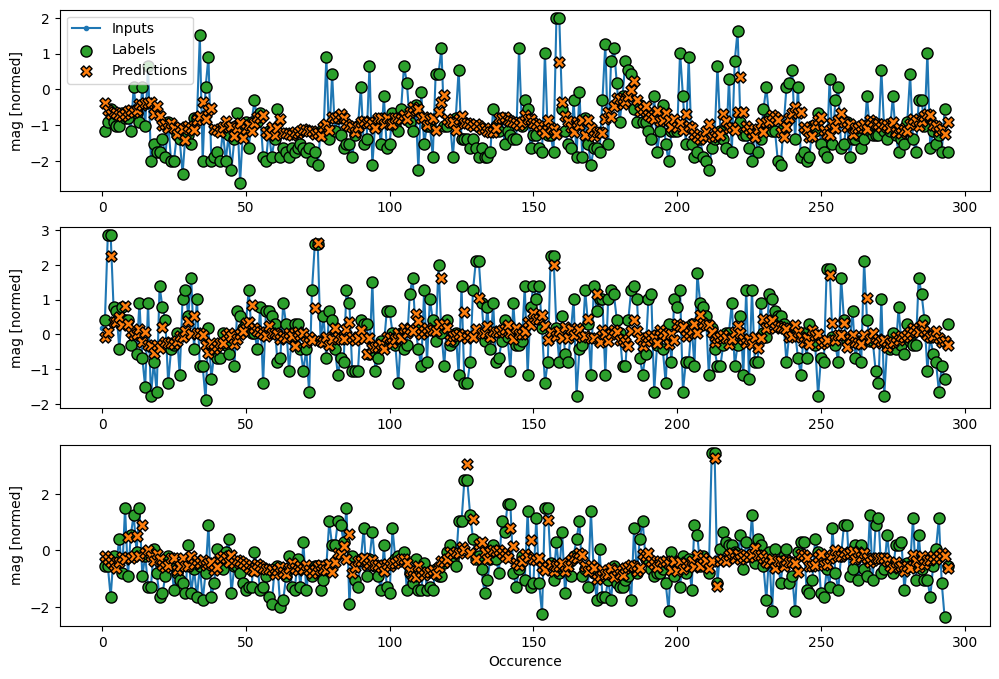

In [ ]:
wide_window.plot(lstm_model)

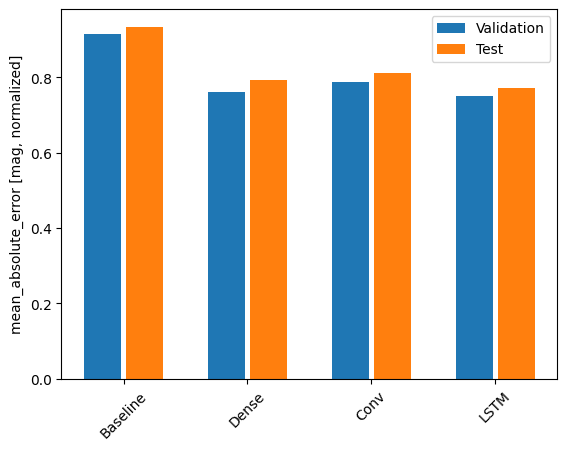

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [mag, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.9347
Dense          : 0.7922
Conv           : 0.8129
LSTM           : 0.7715


In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 5)
Labels shape (batch, time, features): (32, 24, 5)


In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

580/580 [==============================] - 2s 3ms/step - loss: 1.3403 - mean_absolute_error: 0.7120


In [ ]:
dense_all = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
2032/2032 [==============================] - 13s 6ms/step - loss: 0.9705 - mean_absolute_error: 0.7755 - val_loss: 1.2464 - val_mean_absolute_error: 0.9306
Epoch 2/20
2032/2032 [==============================] - 12s 6ms/step - loss: 0.9666 - mean_absolute_error: 0.7739 - val_loss: 1.2460 - val_mean_absolute_error: 0.9333
Epoch 3/20
2032/2032 [==============================] - 10s 5ms/step - loss: 0.9658 - mean_absolute_error: 0.7737 - val_loss: 1.2487 - val_mean_absolute_error: 0.9360
Epoch 4/20
581/581 [==============================] - 2s 4ms/step - loss: 1.2516 - mean_absolute_error: 0.9381


In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features),
])


In [ ]:
%%time
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/20
2023/2023 [==============================] - 24s 11ms/step - loss: 0.9030 - mean_absolute_error: 0.7672 - val_loss: 0.9779 - val_mean_absolute_error: 0.7880
Epoch 2/20
2023/2023 [==============================] - 23s 11ms/step - loss: 0.9002 - mean_absolute_error: 0.7660 - val_loss: 0.9784 - val_mean_absolute_error: 0.7885
Epoch 3/20
572/572 [==============================] - 3s 5ms/step - loss: 0.9790 - mean_absolute_error: 0.7905
CPU times: user 1min 29s, sys: 8.38 s, total: 1min 38s
Wall time: 1min 56s


In [ ]:
conv_model.save('conv_model_out_all.h5')

In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=294, label_width=294, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

Epoch 1/20
2023/2023 [==============================] - 349s 171ms/step - loss: 0.7292 - mean_absolute_error: 0.5894 - val_loss: 0.7712 - val_mean_absolute_error: 0.6148
Epoch 2/20
2023/2023 [==============================] - 322s 159ms/step - loss: 0.7015 - mean_absolute_error: 0.5784 - val_loss: 0.7977 - val_mean_absolute_error: 0.6348
Epoch 3/20
572/572 [==============================] - 28s 49ms/step - loss: 0.8233 - mean_absolute_error: 0.6477

CPU times: user 26min 2s, sys: 27.4 s, total: 26min 30s
Wall time: 17min 24s


In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')